In [218]:
import re
import pandas as pd
from typing import Union, List
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [154]:
# Téléchargement des modules NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/maxime/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/maxime/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Présentation des données

In [2]:
df = pd.read_csv(r"../data/news_dataset.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
df.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,kennedy questions trust of blair lib dem leade...
freq,511,2


In [4]:
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

Le *dataset* est un corpus de 2225 articles de presse anglais catégorisés en 5 types d'article. Il contient 2 colonnes :
* La **catégorie** d'article (tech, business, sport, entertainment, politics)
* Le **texte** brut de l'article

On remarque qu'il y a $(2225 - 2126)$ dupliqués sur le champ texte.

In [5]:
# Suppression des articles dupliqués
df.drop_duplicates(subset=["category", "text"], inplace=True)
df.count()

category    2126
text        2126
dtype: int64

# Exploration des articles

In [27]:
df["text"][9]

'last star wars  not for children  the sixth and final star wars movie may not be suitable for young children  film-maker george lucas has said.  he told us tv show 60 minutes that revenge of the sith would be the darkest and most violent of the series.  i don t think i would take a five or six-year-old to this   he told the cbs programme  to be aired on sunday. lucas predicted the film would get a us rating advising parents some scenes may be unsuitable for under-13s. it opens in the uk and us on 19 may. he said he expected the film would be classified pg-13 - roughly equivalent to a british 12a rating.  the five previous star wars films have all carried less restrictive pg - parental guidance - ratings in the us. in the uk  they have all been passed u - suitable for all - with the exception of attack of the clones  which got a pg rating in 2002. revenge of the sith - the third prequel to the original 1977 star wars film - chronicles the transformation of the heroic anakin skywalker i

In [43]:
df[df["category"] == "tech"]["text"][0][0:1000]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

Le lexique de la catégorie **tech** sera certainement très important pour la classification.

In [64]:
df[df["category"] == "business"]["text"].iloc[3][0:1000]

's korean credit card firm rescued south korea s largest credit card firm has averted liquidation following a one trillion won ($960m; £499m) bail-out.  lg card had been threatened with collapse because of its huge debts but the firm s creditors and its former parent have stepped in to rescue it. a consortium of creditors and lg group  a family owned conglomerate  have each put up $480m to stabilise the firm. lg card has seven million customers and its collapse would have sent shockwaves through the country s economy.  the firm s creditors - which own 99% of lg card - have been trying to agree a deal to secure its future for several weeks. they took control of the company in january when it avoided bankruptcy only through a $4.5bn bail-out.  they had threatened to delist the company  a move which would have triggered massive debt redemptions and forced the company into bankruptcy  unless agreement was reached on its future funding.  lg card will not need any more financial aid after th

Les sommes monétaires ou les pourcentages pourraient aider à caractériser la catégorie **business**. Il y a des risques pour faire des erreurs avec d'autres classes comme **entertainement** ou **politics**.

In [59]:
df[df["category"] == "sport"]["text"].iloc[2][0:1000]

'henman hopes ended in dubai third seed tim henman slumped to a straight sets defeat in his rain-interrupted dubai open quarter-final against ivan ljubicic.  the croatian eighth seed booked his place in the last four with a 7-5 6-4 victory over the british number one. henman had looked on course to level the match after going 2-0 up in the second set  but his progress was halted as the rain intervened again. ljubicic hit back after the break to seal a fourth straight win over henman. earlier in the day  spanish fifth seed tommy robredo secured his semi-final place when he beat nicolas kiefer of germany 6-4 6-4. afterwards  henman was left cursing the weather and the umpire after seven breaks for rain during the match.  it was incredibly frustrating   henman said.  it s raining and the umpire doesn t take control.  he kept telling us to play till the end of the game. but if it s raining  you come off - the score s irrelevant.  it couldn t be more frustrating as i was very happy with my 

La catégorie **sport** se démarque forcément par son lexique et la présentation des scores.

In [68]:
df[df["category"] == "entertainment"]["text"].iloc[0][0:1000]

'ocean s twelve raids box office ocean s twelve  the crime caper sequel starring george clooney  brad pitt and julia roberts  has gone straight to number one in the us box office chart.  it took $40.8m (£21m) in weekend ticket sales  according to studio estimates. the sequel follows the master criminals as they try to pull off three major heists across europe. it knocked last week s number one  national treasure  into third place. wesley snipes  blade: trinity was in second  taking $16.1m (£8.4m). rounding out the top five was animated fable the polar express  starring tom hanks  and festive comedy christmas with the kranks.  ocean s twelve box office triumph marks the fourth-biggest opening for a december release in the us  after the three films in the lord of the rings trilogy. the sequel narrowly beat its 2001 predecessor  ocean s eleven which took $38.1m (£19.8m) on its opening weekend and $184m (£95.8m) in total. a remake of the 1960s film  starring frank sinatra and the rat pack 

La catégorie **entertainment** devra s'aider de son lexique. Mais elle risque d'être difficile à classifier si elle donne trop de chiffres.

In [71]:
df[df["category"] == "politics"]["text"].iloc[0][0:1000]

'howard hits back at mongrel jibe michael howard has said a claim by peter hain that the tory leader is acting like an  attack mongrel  shows labour is  rattled  by the opposition.  in an upbeat speech to his party s spring conference in brighton  he said labour s campaigning tactics proved the tories were hitting home. mr hain made the claim about tory tactics in the anti-terror bill debate.  something tells me that someone  somewhere out there is just a little bit rattled   mr howard said. mr hain  leader of the commons  told bbc radio four s today programme that mr howard s stance on the government s anti-terrorism legislation was putting the country at risk. he then accused the tory leader of behaving like an  attack mongrel  and  playing opposition for opposition sake .  mr howard told his party that labour would  do anything  say anything  claim anything to cling on to office at all costs .  so far this year they have compared me to fagin  to shylock and to a flying pig. this mor

Les noms propres et les sujets récurrents seront certainement décisifs pour ce qui est de la catégorie **politics**.

In [39]:
# Est-ce qu'il y a des lettres majuscules ?
for t in df["text"]:
    if t != t.lower():
        print(t); break

In [88]:
# Est-ce qu'il y a de la ponctuation et d'autres symboles ?
s = set()
punct = ',.;:!?"\'()[]{}%#&/§%$£€-*+='
for t in df["text"]:
    for c in t:
        if c in punct:
            s.add(c)
print(s)

{';', ':', '*', '$', '+', '.', ')', '&', '-', ']', '%', '[', '(', '£', '#', '=', '/', '!'}


In [105]:
# Il y a des caractères spéciaux encodés avec des codes HTML
i = df["text"][99].find('#')
df["text"][99][i-10:i+10]

'the clich&#233;d hip'

In [134]:
# Les slash séparent deux mots
i = df["text"][3][1000:].find('/')
df["text"][3][1000:][i-10:i+10]

'e  swindon/notts co '

In [31]:
# Est-ce qu'il y a de URL ?
for t in df["text"]: 
    if 'http' in t: print(t); break

In [32]:
# Est-ce qu'il y a des balises HTML ?
for t in df["text"]:
    if '<' in t: print(t); break

Lorsqu'on regarde des exemples d'articles on remarque qu'ils sont déjà bien nettoyés :
* Tout est en minuscule.
* Il n'y a pas de liens.
* Il n'y a pas de balises HTML.
* Les apostrophes ont été retirées.
* Il ne reste presque que les points comme ponctuation.

Il reste cependant quelques améliorations possibles :
* Supprimer les stop words c'est-à-dire les mots les plus courants.
* Stemmatiser/Lemmatiser les mots.
* Supprimer les codes HTML.
* Supprimer les slashs séparateurs de mots.
* Supprimer la ponctuation restante.
* Supprimer les espaces inutiles (la tokenization peut s'en charger).
* Supprimer les tirets entre morceaux de phrase.
* Supprimer les sommes d'argent mais garder seulement le symbole de monnaie.

# Fonction de nettoyage

In [234]:
def clean_text(text: str, tokenize:bool=True, exclude_words:List[str]=["say", "said"]) -> Union[str, List[str]]:
    """
    Fonction de nettoyage d'un article de presse.
    
    :param text: Texte de l'article sous forme d'une string
    :param tokenize: Si True le résultat est renvoyé sous forme 
    d'une liste de string sinon sous forme d'une string simple
    :param exclude_words: Mots sans valeur ajoutée à exclure
    :return: string ou liste de string du texte nettoyé
    """
    # Passage en minuscules
    text = text.lower()
    
    # Suppression des codes HTML
    text = re.sub(r'&#[0-9]+;', '', text)
    
    # Suppression des slashs séparateurs de mots
    text = re.sub(r'(\w+)/(\w+)', r'\1 \2', text)
    
    # Suppression des sommes d'argent et conservation du symbole monétaire
    text = re.sub(r'\$[0-9]+([.][0-9]*)?(m|bn)?', '$', text)
    text = re.sub(r'£[0-9]+([.][0-9]*)?(m|bn)?', '£', text)
    
    # Suppression des tirets séparateurs de phrase
    text = text.replace(' - ', ' ')
    
    # Remplacement des espaces multiples par des espaces simples
    text = re.sub(r'\s+', ' ', text)
    
    # Suppression de la ponctuation restante
    text = re.sub(r'[.,;:!?"()\[\]{}]', '', text)
    
    # Découpage en liste de tokens
    tokens = word_tokenize(text)
    
    # Stemming = On cherche la racine des mots
    ps = PorterStemmer()
    # Mots courants ayant peu de valeur ajoutée
    stop_words = set(stopwords.words('english'))
    # Mots exclus sans valeur ajoutée
    stop_words = stop_words.union(set(exclude_words))
    tokens = [ps.stem(w) for w in tokens
              # Suppression des stop words et mots exclus
              if w not in stop_words]
    
    if not tokenize:
        return ' '.join(tokens)
    return tokens

In [235]:
df["text_cleaned"] = df["text"].apply(lambda t: clean_text(t, tokenize=False))

In [236]:
df["text_cleaned"][4]

'ocean twelv raid box offic ocean twelv crime caper sequel star georg clooney brad pitt julia robert gone straight number one us box offic chart took $ £ weekend ticket sale accord studio estim sequel follow master crimin tri pull three major heist across europ knock last week number one nation treasur third place wesley snipe blade triniti second take $ £ round top five anim fabl polar express star tom hank festiv comedi christma krank ocean twelv box offic triumph mark fourth-biggest open decemb releas us three film lord ring trilog sequel narrowli beat 2001 predecessor ocean eleven took $ £ open weekend $ £ total remak 1960 film star frank sinatra rat pack ocean eleven direct oscar-win director steven soderbergh soderbergh return direct hit sequel reunit clooney pitt robert matt damon andi garcia elliott gould catherin zeta-jon join all-star cast fun good holiday movi dan fellman presid distribut warner bro howev us critic less complimentari $ £ project lo angel time label dispirit 

In [237]:
df["text"][4]

'ocean s twelve raids box office ocean s twelve  the crime caper sequel starring george clooney  brad pitt and julia roberts  has gone straight to number one in the us box office chart.  it took $40.8m (£21m) in weekend ticket sales  according to studio estimates. the sequel follows the master criminals as they try to pull off three major heists across europe. it knocked last week s number one  national treasure  into third place. wesley snipes  blade: trinity was in second  taking $16.1m (£8.4m). rounding out the top five was animated fable the polar express  starring tom hanks  and festive comedy christmas with the kranks.  ocean s twelve box office triumph marks the fourth-biggest opening for a december release in the us  after the three films in the lord of the rings trilogy. the sequel narrowly beat its 2001 predecessor  ocean s eleven which took $38.1m (£19.8m) on its opening weekend and $184m (£95.8m) in total. a remake of the 1960s film  starring frank sinatra and the rat pack 

On a construit une fonction de nettoyage simple et adaptée à notre cas d'usage pour les articles de presse. 
Son rôle est de diminuer la taille du vocabulaire et supprimer les mots ayant peu de valeur ajoutée.
On pourra l'utiliser avant la vectorisation de nos données. 



# Analyse de la répartition

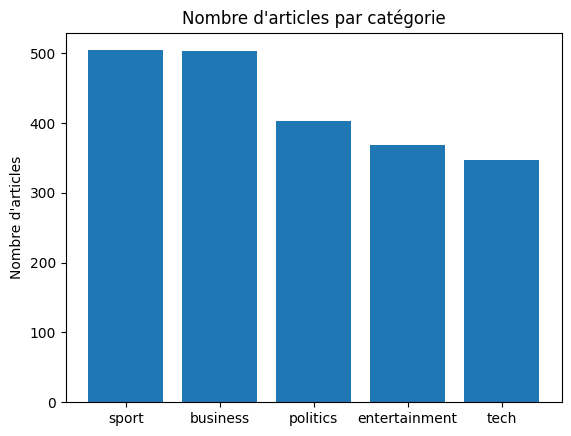

In [238]:
vc = df["category"].value_counts()
plt.bar(vc.index, vc)
plt.ylabel("Nombre d'articles")
plt.title("Nombre d'articles par catégorie")
plt.show()

Il faudra faire attention lors de l'apprentissage à équilibrer le nombre d'obervations par classe. Si les catégories **sport** et **business** sont les deux les plus représentées, les autres catégories sont moins présentes avec jusqu'à 31% moins d'observations pour la catégorie **tech** comparée à la catégorie **sport**. 

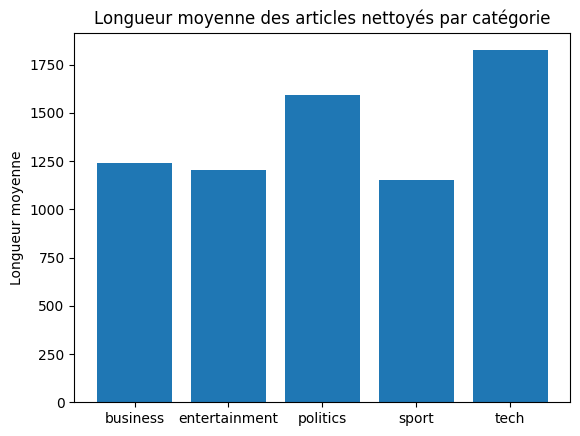

In [239]:
df["length"] = df["text_cleaned"].str.len()
tml = df.groupby("category").agg({'length': 'mean'})
plt.bar(tml.index, tml["length"])
plt.ylabel("Longueur moyenne")
plt.title("Longueur moyenne des articles nettoyés par catégorie")
plt.show()

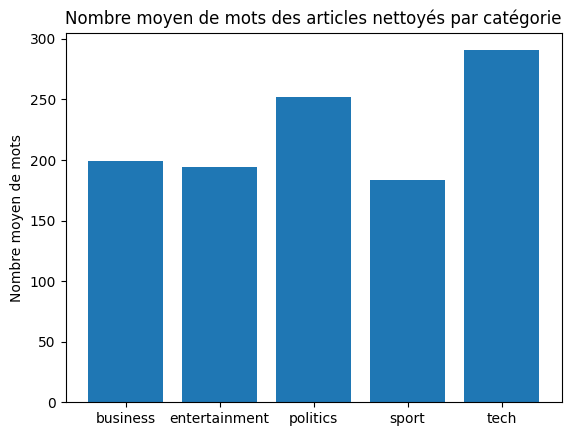

In [240]:
df["length"] = df["text_cleaned"].apply(lambda t: len(word_tokenize(t)))
tml = df.groupby("category").agg({'length': 'mean'})
plt.bar(tml.index, tml["length"])
plt.ylabel("Nombre moyen de mots")
plt.title("Nombre moyen de mots des articles nettoyés par catégorie")
plt.show()

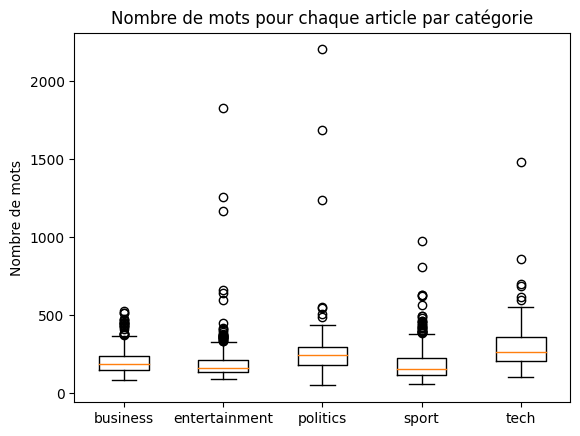

In [241]:
category = ["business", "entertainment", "politics", "sport", "tech"]
l = [df[df["category"] == c]["length"] for c in category]
plt.boxplot(l, labels=category)
plt.ylabel("Nombre de mots")
plt.title("Nombre de mots pour chaque article par catégorie")
plt.show()

Les articles les plus longs en moyenne sont de la catégorie **tech** suivie par la catégorie **politics**. Les autres catégories sont plus ou moins à égalité.

On remarque qu'il y a quelques *outliers* très grands dans toutes les catégories sauf pour **business** et **sport** où les articles restent toujours concis.

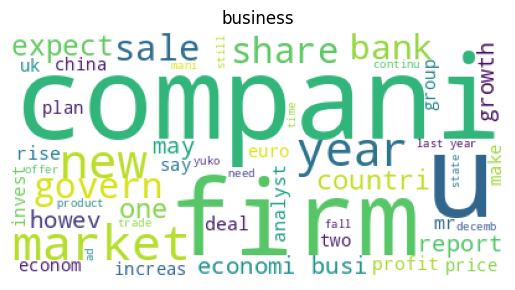

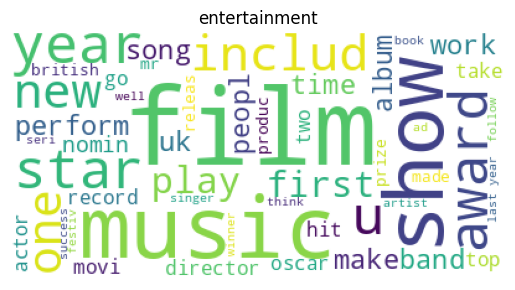

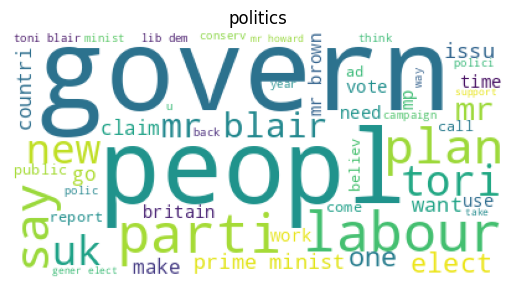

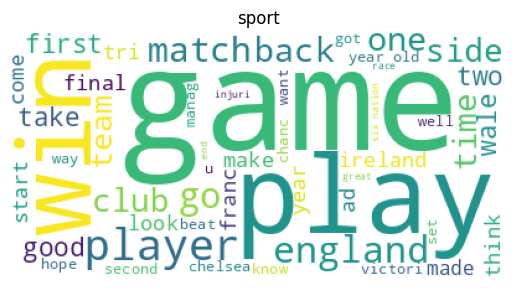

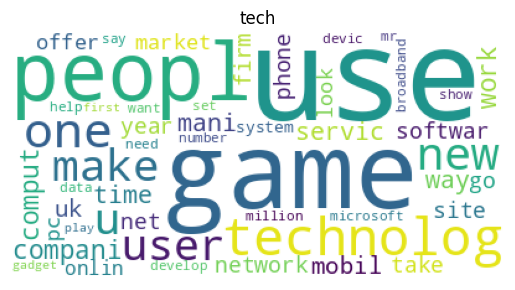

In [242]:
l = [df[df["category"] == c]["text_cleaned"] for c in category]
for i in range(len(l)):
    text = ""
    for t in l[i]:
        text += " "+t
    wordcloud = WordCloud(background_color='white', max_words=50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(category[i])
    plt.show()

Les nuages de mots précédents nous montrent bien que le lexique permet bien de caractériser une catégorie avec des mots revenant souvent. Par exemple, pour la catégorie **business** les mots **compani**, **firm** ou encore **market** sont très fréquents. 

Pour avoir ces beaux nuages de mots le nettoyage préalable du corpus était nécessaire. Autrement, seuls les *stops words* seraient ressortis. De plus, avec le *stemming* on a regroupé les mots ayant la même racine.

# Vectorisation
La vectorisation est la partie du preprocessing qui consiste à transformer en vecteurs de nombres les articles.
Cette opération a une énorme influence sur les modèles d'apprentissage. C'est pourquoi nous la traiterons directement dans les notebooks chargés de comparer les modèles.